# SIRD implementation using Python



In [193]:
import pandas as pd  
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [194]:
#Loading Dataset 
df_states = pd.read_csv("states.csv") # data cases in different states
df_pop = pd.read_csv("3. population_india_census2011.csv") #population census data

In [195]:
# Storing population of state
state='India' #change the country/state/district/city according to what name it 
              # has in the dataset
#grabbing out the population of the state from pupulation census data
if state=='India':
    N = df_pop['Population'].sum()
else:
    N = df_pop[df_pop["State / Union Territory"] == state]['Population'].tolist()[0]
print('The Population of {0} is {1}'.format(state,int(N)))

The Population of India is 1210568111


In [196]:
# Performing operations to get the data for State of Maharashtra
df_state = df_states[df_states['State']==state].fillna(0)
df_state = df_state.reset_index().drop('index',axis=1)
df_state = df_state.drop('State',axis=1)
df_state

,Date,Confirmed,Recovered,Deceased,Other,Tested
0,2020-01-30,1,0,0,0,0.0
1,2020-02-02,2,0,0,0,0.0
2,2020-02-03,3,0,0,0,0.0
3,2020-02-14,3,3,0,0,0.0
4,2020-03-02,5,3,0,0,0.0
...,...,...,...,...,...,...
214,2020-09-28,6143019,5098583,96351,863,73110041.0
215,2020-09-29,6223519,5184733,97529,883,74196729.0
216,2020-09-30,6310267,5270007,98708,909,75619781.0
217,2020-10-01,6391960,5348653,99804,918,76717728.0


## Checking if Total cases are more than  1% of the population


In [197]:
percent = (df_state['Confirmed'].iloc[len(df_state['Confirmed'])-1] / N ) *100
if percent > 1:
    print('Yes the confirmed cases are more than 1% of the total population ({0:.3f}%)'.format(percent))
else:
    print('No the confirmed cases are less than 1% of the total population ({0:.3f}%)'.format(percent))

No the confirmed cases are less than 1% of the total population (0.531%)


# Adding Infected,ΔC,ΔD,ΔR,β,δ,γ to dataFrame

I(t) = C(t) – [R(t) + D(t)] The number of Infected (aka active cases) 

ΔC(t) = C(t+1) – C(t) New cases

ΔD(t) = D(t+1) – D(t) Daily deaths

ΔR(t) = R(t+1) - R(t) Daily recoveries

We use the above formulas to calculate the respective variables 

The calculated values are added as columns to our state extracted data 

make sure the column names exist and are typed correctly

In [198]:
# infected
df_state['Infected'] = df_state['Confirmed'] - (df_state["Recovered"] + df_state['Deceased'])

# delta recovered,delta Confirmed , Delta Dead calculation and addition to table
#diff() just subracts current - previous value and returns it
df_state['Delta_C'] = df_state['Confirmed'].diff(-1) * -1 
df_state['Delta_D'] = df_state['Deceased'].diff( -1) * -1
df_state['Delta_R'] = df_state["Recovered"].diff(-1) * -1

# beta,gamma and delta Calculation
# for beta if confirmed cases are more than 1% ,we need to use different formula
if percent > 1: #if more than 1%
    df_state['beta'] = (df_state['Delta_C']/df_state['Infected']) * ( N/(N-df_state['Confirmed']))
else :          #if less than 1%
    df_state['beta'] = (df_state['Delta_C']/df_state['Infected'])  
df_state['gamma'] = df_state['Delta_R']/df_state['Infected']
df_state['delta'] = df_state['Delta_D']/df_state['Infected']



# adding r0 and R
 r0 = β – (γ + δ)   this is  the (per capita) growth rate per day
 
  R0 = β/(γ + δ)    this is the basic reproductive number

In [199]:
df_state['r0'] = df_state['beta'] - ( df_state['gamma'] + df_state['delta'] )
df_state['R0'] = df_state['beta'] / ( df_state['gamma'] + df_state['delta'] )


In [200]:
# replacing infinite values with zero as R0 has division with zero 
# which resulted in infinte values
df_state = df_state.replace([np.inf, -np.inf], np.nan)
df_state = df_state.fillna(0)

In [201]:
df_state.head()

,Date,Confirmed,Recovered,Deceased,Other,Tested,Infected,Delta_C,Delta_D,Delta_R,beta,gamma,delta,r0,R0
0,2020-01-30,1,0,0,0,0.0,1,1.0,-0.0,-0.0,1.0,-0.0,-0.0,1.0,0.0
1,2020-02-02,2,0,0,0,0.0,2,1.0,-0.0,-0.0,0.5,-0.0,-0.0,0.5,0.0
2,2020-02-03,3,0,0,0,0.0,3,-0.0,-0.0,3.0,-0.0,1.0,-0.0,-1.0,-0.0
3,2020-02-14,3,3,0,0,0.0,0,2.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-02,5,3,0,0,0.0,2,1.0,-0.0,-0.0,0.5,-0.0,-0.0,0.5,0.0


# Saves the data of a particular State 

The below cell creates a csv file in state data folder

In [202]:
import os 
if os.path.exists('state data//'):
    df_state.to_csv("state data//{0}_data.csv".format(state),index=False)
else:
    os.mkdir('state data//')
    df_state.to_csv("state data//{0}_data.csv".format(state),index=False)

## Finding the index where total confirmed cases exceed 100 

In [203]:
cases = None
for i in range(len(df_state['Confirmed'])):
    cases = df_state['Confirmed'][i]
    if cases > 100:
        cases = i
        print('The total Confirmed cases exceed 100 for {0} at index '.format(state),cases)
        break
else:
    print('Confirmed Cases dont exceed 100')
    print('Need more Data to Continue.....')
    raise Exception("Sorry,We dont have enough values to run the model") 


The total Confirmed cases exceed 100 for India at index  16


# Smoothing beta gamma and delta.

#### As the original data has  noise in it we need to smooth data

Smoothing beta and delta with a fraction of 0.1 and 
gamma with fraction of 0.2


The LOWESS fraction controls the smoothness of the curve. For example, if it is 1.0, then the LOWESS curve is a single straight line. In general, the smaller the fraction, the more that LOWESS curve follows individual data points.

In [204]:
#this is our smoothing Function
from statsmodels.nonparametric.smoothers_lowess import lowess
def smooth(df,col,fraction):

    df_lowess = pd.DataFrame(lowess(df[col],
                                 np.arange(len(df[col])), 
                                 frac=fraction)[:, 1], index=df.index, 
                                  columns=[col])
    return df_lowess

we smooth the data only after C(t) exceeds 100 cases and use a constant for the period before, set equal to the first smoothed estimate. 

For this we look at our data and find out when the cases exceed 100,

from that point in time onwards we smooth delta,beta and gamma

The points before when Confirmed > 100,are all set to the first smoothed estimate

In [205]:
df_sm = df_state.drop(list(range(cases)))
df_smooth = smooth(df_sm,'beta',0.1)
df_smooth['gamma'] = smooth(df_sm,'gamma',0.2)
df_smooth['delta'] = smooth(df_sm,'delta',0.1)


In [207]:
# before the confirmed cases cross 100
# all the values are set  equal to the first smoothed estimate
for i in range(-1,-(cases+1),-1):
    df_smooth.loc[i] = [df_smooth['beta'][cases],df_smooth['gamma'][cases] ,df_smooth['delta'][cases]]
    
df_smooth.index = df_smooth.index + cases  # shifting index
df_smooth = df_smooth.sort_index()    
df_smooth = df_smooth.reset_index()
df_smooth = df_smooth.drop('index',axis=1)

In [208]:
# Adding smoothed r0 and R0 to the smoothed data
df_smooth['r0'] = df_smooth['beta'] - df_smooth['delta'] - df_smooth['gamma']
df_smooth

,beta,gamma,delta,r0
0,0.157773,-0.003547,-0.000164,0.161484
1,0.157773,-0.003547,-0.000164,0.161484
2,0.157773,-0.003547,-0.000164,0.161484
3,0.157773,-0.003547,-0.000164,0.161484
4,0.157773,-0.003547,-0.000164,0.161484
...,...,...,...,...
214,0.086222,0.090616,0.001134,-0.005528
215,0.086100,0.090933,0.001135,-0.005969
216,0.085990,0.091245,0.001138,-0.006393
217,0.085892,0.091550,0.001140,-0.006798


# Saving smoothed estimates to csv file

In [209]:
df_smooth.to_csv("state data//{0}_smoothed_data.csv".format(state),index=False)

# The equations on which our model is defined

S(t+1) = S – βSI/N

I(t+1) = I + βSI/N – γI – δI

R(t+1) = R + γI

D(t+1) = D + δI

S:Susceptible , I:Infected , R:Recovered , D:Deceased

In [210]:
#defined model of SIRD
def SIRD(S,I,R,D,df_smooth):
    s_ , i_ , r_ , d_ = [],[],[],[]
    for i in range(len(df_smooth)):
        S = S - (df_smooth.loc[i]['beta']*S*I)/N
        I = I + ((df_smooth.loc[i]['beta']*S*I)/N) \
             - df_smooth.loc[i]['gamma']*I - df_smooth.loc[i]['delta']*I
        R = R + df_smooth.loc[i]['gamma']*I
        D = D + df_smooth.loc[i]['delta']*I
        s_.append(S)
        i_.append(I)
        r_.append(R)
        d_.append(D)
    df = pd.DataFrame(columns=['Susceptible','Confirmed','Infected','Recovered','Deceased'])
    df['Susceptible'] = s_
    df['Infected']    = i_
    df['Recovered']   = r_
    df['Deceased']    = d_
    df['Confirmed']   = df['Infected'] + df['Recovered'] + df['Deceased']
    
    return df
    
    

# Initial values for our SIRD model
### S(0) = N ,D(0)=R(0)=0
###  C = I + R + D


 I(0) must be determined from the data .


# Measure of Model Fit 
## predR² = 1 – Σ(Y – X)2 / Σ[X – mean(X)]2

we use numer = Σ(Y – X)2 and denom = Σ[X – mean(X)]2



In [211]:
def PredR_sq(df_pred,df_orig,col):
    '''col represents the column on which predR_squared will be applied'''
    
    n = (df_pred[col] - df_orig[col])**2 
    numer = n.sum() #summation
    mean_x = df_orig[col].mean()
    d = (df_orig[col] - mean_x)**2
    denom = d.sum() #summation
    pred_rsq = 1 - (numer/denom)
    
    return pred_rsq

## For calculation of optimal value of I 


In [212]:
def optimize_I(i):
    '''Finds the best value for I(0) that we should put in our model'''
    S = N
    I = i
    R = 0
    D = 0
    df_pred = SIRD(S,I,R,D,df_smooth)
    score = PredR_sq(df_pred,df_state,'Confirmed')
    ratio = df_pred['Confirmed'].iloc[-1]/ df_state['Confirmed'].iloc[-1]

    I = I / ratio
    print('I={0:10f}'.format(I))
    return I


In [213]:
i=1
while True:
    S = N
    I = optimize_I(i)
    i = I
    R = 0
    D = 0
    df_pred = SIRD(S,I,R,D,df_smooth)
    score = PredR_sq(df_pred,df_state,'Confirmed')
    print("Score = {0:.6f}".format(score))
    print('The closer the value is to 1 the acuurate the Predictions will be')
    
    if score > 0.99:
        print('For I ={0:10f} gives us best score'.format(I))
        break
    print('-----------------------')

I=  6.474634
Score = 0.999373
The closer the value is to 1 the acuurate the Predictions will be
For I =  6.474634 gives us best score


# Plots

predicted vs Original 

Scattered are the original datapoints

Curves or lines are the predicted datapoints

#### Here ax.scatter plots the scatter plot 

first and second arguements are x and y axis data respectively

s represents the size of individual marker

#### ax.plot is used to plot the curve of predicted values

first and second arguements are x and y axis data

linewidth can be modified by changing the value

#### xticks are used to control labels on x axis

the dates at index in xticks are only displayed as labels



In [214]:
#creating folders where graphs will be saved 
if os.path.exists('graphs//'):
    if os.path.exists('graphs//{0}//'.format(state)):
        pass
    else:
        os.mkdir('graphs//{0}//'.format(state))
else :
    os.mkdir('graphs//')
    os.mkdir('graphs//{0}//'.format(state))
    

In [215]:
# creating 5 equally spaced ticks on x axis
last = len(df_state['Confirmed'])
xticks = [x*(last//4 -1 ) for x in range(5)]
xticks

[0, 53, 106, 159, 212]

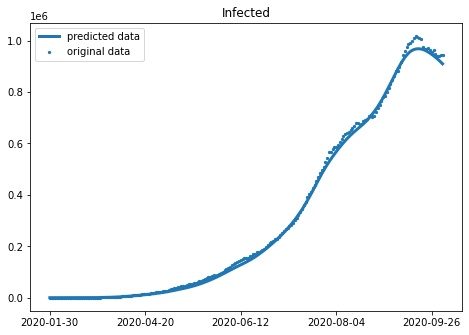

In [216]:
#infected
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['Infected'],s=5,label='original data')
ax.plot(df_state['Date'],df_pred['Infected'],linewidth=3,label='predicted data')
ax.set_xticks(xticks)
ax.set_title('Infected')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Infected.jpg'.format(state),bbox_inches='tight',dpi=200) #uncomment if want to save the graph as image
plt.show()


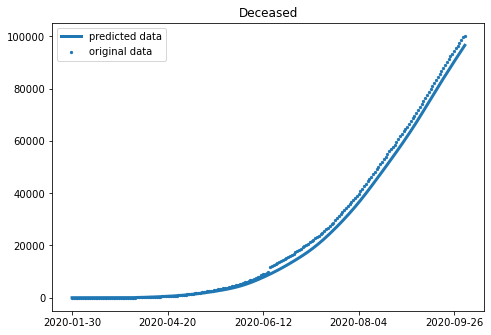

In [217]:
#Deceased
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['Deceased'],s=5,label='original data')
ax.plot(df_state['Date'],df_pred['Deceased'],linewidth=3,label='predicted data')
ax.set_xticks(xticks)
ax.set_title('Deceased')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Deceased.jpg'.format(state),bbox_inches='tight',dpi=200) #uncomment if want to save the graph as image
plt.show()


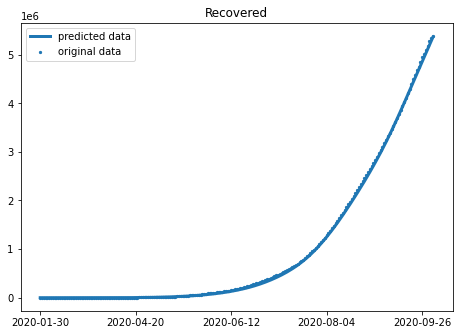

In [218]:
#Recovered
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['Recovered'],s=5,label='original data')
ax.plot(df_state['Date'],df_pred['Recovered'],linewidth=3,label='predicted data')
ax.set_xticks(xticks)
ax.set_title('Recovered')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Recovered.jpg'.format(state),bbox_inches='tight',dpi=200) #uncomment if want to save the graph as image
plt.show()

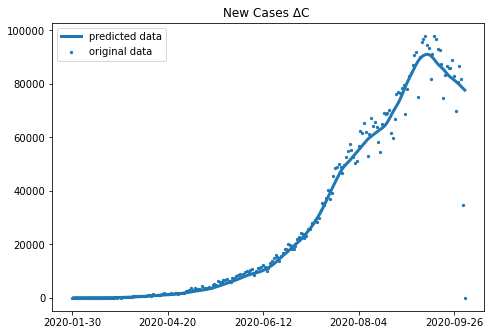

In [219]:
#New Cases deltaC
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['Delta_C'],s=5,label='original data')
ax.plot(df_state['Date'],df_pred['Confirmed'].diff(),linewidth=3,label='predicted data')
ax.set_xticks(xticks)
ax.set_title('New Cases ΔC ')
ax.legend(loc=0)
plt.savefig('graphs//{0}//New Cases.jpg'.format(state),bbox_inches='tight',dpi=200)
plt.show()

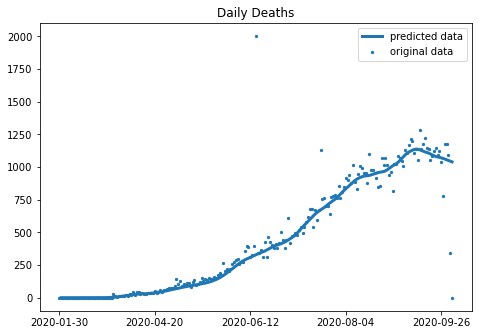

In [220]:
#Daily deaths delta_D
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['Delta_D'],s=5,label='original data')
ax.plot(df_state['Date'],df_pred['Deceased'].diff(),linewidth=3,label='predicted data')
ax.set_xticks(xticks)
ax.set_title('Daily Deaths')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Daily Deaths.jpg'.format(state),bbox_inches='tight',dpi=200)
plt.show()


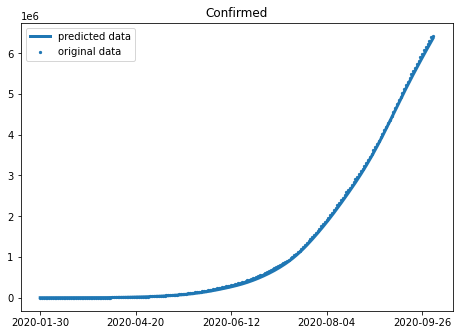

In [221]:
#Confirmed
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['Confirmed'],s=5,label='original data')
ax.plot(df_state['Date'],df_pred['Confirmed'],linewidth=3,label='predicted data')
ax.set_xticks(xticks)
ax.set_title('Confirmed')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Confirmed.jpg'.format(state),bbox_inches='tight',dpi=200)
plt.show()


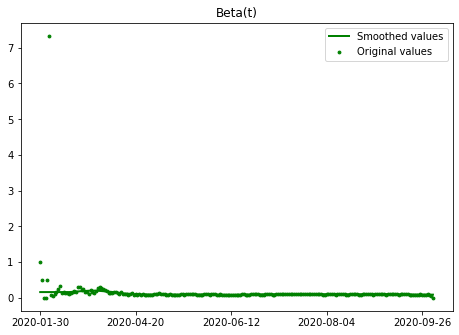

In [222]:
#beta
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['beta'],s=8,c='g',label='Original values')
ax.plot(df_state['Date'],df_smooth['beta'],linewidth=2,c='g',label='Smoothed values')
ax.set_xticks(xticks)
ax.set_title('Beta(t)')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Beta.jpg'.format(state),bbox_inches='tight',dpi=200)
plt.show()


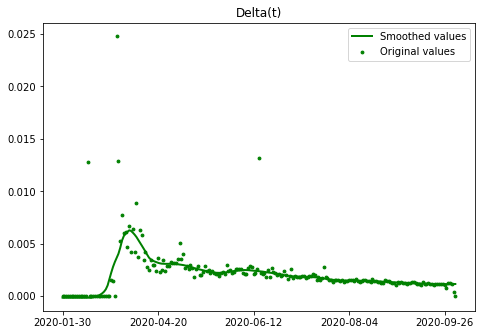

In [223]:
#Delta
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.scatter(df_state['Date'],df_state['delta'],s=8,c='g',label='Original values')
ax.plot(df_state['Date'],df_smooth['delta'],linewidth=2,c='g',label='Smoothed values')
ax.set_xticks(xticks)
ax.set_title('Delta(t)')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Delta.jpg'.format(state),bbox_inches='tight',dpi=200)
plt.show()


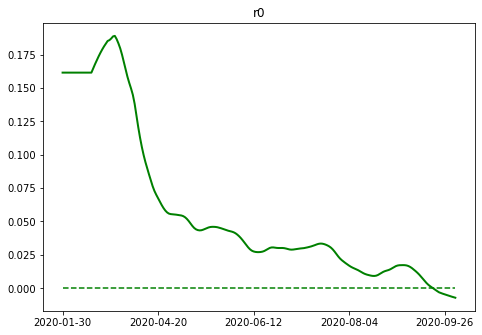

In [224]:
#r0
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(df_state['Date'],[0]*len(df_smooth['r0']),'--g')
ax.plot(df_state['Date'],df_smooth['r0'],linewidth=2,c='g')
ax.set_xticks(xticks)
ax.set_title('r0')
plt.savefig('graphs//{0}//r0.jpg'.format(state),bbox_inches='tight',dpi=200)
plt.show()

### Extra plots for gamma,R(t) and delta(R,I)

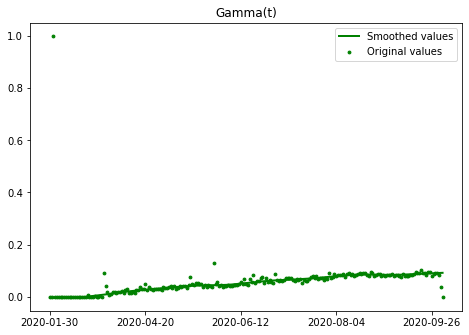

In [225]:
#Gamma
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.scatter(df_state['Date'],df_state['gamma'],s=8,c='g',label='Original values')
ax.plot(df_state['Date'],df_smooth['gamma'],linewidth=2,c='g',label='Smoothed values')
ax.set_xticks(xticks)
ax.set_title('Gamma(t)')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Gamma.jpg'.format(state),bbox_inches='tight',dpi=200)
plt.show()

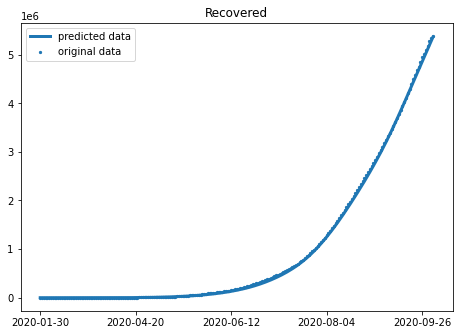

In [226]:
# Recovered
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['Recovered'],s=5,label='original data')
ax.plot(df_state['Date'],df_pred['Recovered'],linewidth=3,label='predicted data')
ax.set_xticks(xticks)
ax.set_title('Recovered')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Recovered.jpg'.format(state),bbox_inches='tight',dpi=200)
plt.show()

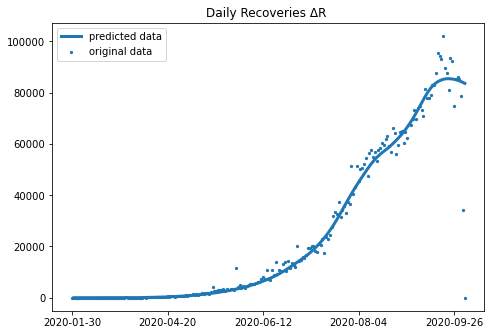

In [227]:
#Daily recoveries  deltaR
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['Delta_R'],s=5,label='original data')
ax.plot(df_state['Date'],df_pred['Recovered'].diff(),linewidth=3,label='predicted data')
ax.set_xticks(xticks)
ax.set_title('Daily Recoveries ΔR ')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Daily Recoveries ΔR.jpg'.format(state),bbox_inches='tight',dpi=200)
plt.show()

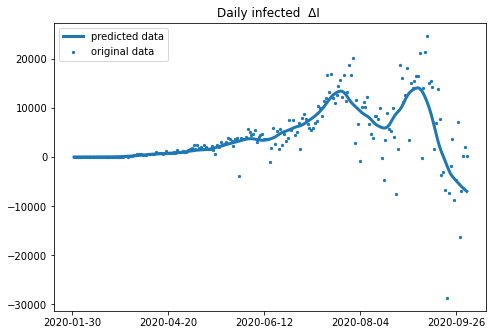

In [228]:
#Daily infected  ΔI
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_state['Date'],df_state['Infected'].diff(),s=5,label='original data')
ax.plot(df_state['Date'],df_pred['Infected'].diff(),linewidth=3,label='predicted data')
ax.set_xticks(xticks)
ax.set_title('Daily infected  ΔI ')
ax.legend(loc=0)
plt.savefig('graphs//{0}//Daily infected  ΔI.jpg'.format(state),bbox_inches='tight',dpi=200) 
plt.show()